https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf

- Have content loss function that measures how different two images are in terms of content and a style loss function for style. Create an image that simultaneously minimizes content loss and style loss
- Paper talks about "perceptual" differences between the images, not pixel difference


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import PIL
import matplotlib.pyplot as plt
import numpy as np
import copy
import torch.optim as optim

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def prep_img(img_path, img_size):
  # preprocess image -> resize and turn into tensor
  loader = transforms.Compose(
      [transforms.Resize(img_size), transforms.ToTensor()]
  )
  image = PIL.Image.open(img_path)
  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float) # add image to gpu

# tensor -> image
def show_img(tensor):
  # move tensor back to cpu for matplotlib
  image = tensor.cpu().clone()
  image = image.squeeze(0)
  image = transforms.ToPILImage()(image)
  plt.imshow(image)
  plt.show()

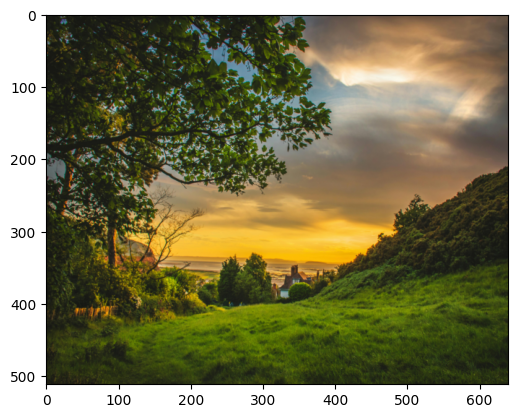

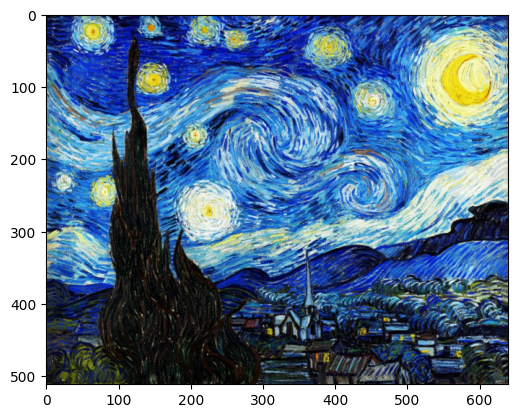

In [6]:
content_img = prep_img('/content/drive/MyDrive/VGG Style Transfer/content_img.jpg', (512, 640))
style_img = prep_img('/content/drive/MyDrive/VGG Style Transfer/starry_night.jpg', (512, 640))
show_img(content_img)
show_img(style_img)

# VGG

In [7]:
model = models.vgg16(pretrained=True).features.to(device).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 189MB/s]


In [8]:
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [9]:
model_norm_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
model_norm_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
  def __init__(self, mean, std):
    super().__init__()
    self.mean = mean.clone().view(-1, 1, 1)
    self.std = std.clone().view(-1, 1, 1)

  def forward(self, img):
    return (img - self.mean) / self.std

# Style

In [10]:
def gram_matrix(tensor):
  # a = batch size, b = # of filters, c = height of feature map, d = width of feature map
  a, b, c, d = tensor.size()
  features = tensor.view(a * b, c * d)
  gram = torch.mm(features, features.t())
  return gram.div(a * b * c * d)

class StyleLoss(nn.Module):
  def __init__(self, target_features):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_features).detach()

  def forward(self, input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input


In [11]:
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def compute_style_loss(cnn, style_img, gen_img):
  # copy cnn so we don't modify original
  cnn = copy.deepcopy(cnn)
  normalization = Normalization(model_norm_mean, model_norm_std).to(device)
  style_losses = []

  model = nn.Sequential(normalization)

  i = 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else:
      pass
    model.add_module(name, layer)

    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)

  for i in range(len(model)-1, -1, -1):
    if isinstance(model[i], StyleLoss):
      break

  # don't use fc
  model = model[:(i+1)]
  return model, style_losses

In [12]:
def style_reconstruction(cnn, style_img, gen_img, iterations):
  model, style_losses = compute_style_loss(cnn, style_img, gen_img)
  optimizer = optim.LBFGS([gen_img.requires_grad_()])

  run = [0]

  while run[0] <= iterations:
    def closure():
      gen_img.data.clamp_(0, 1)
      optimizer.zero_grad()
      model(gen_img)
      style_score = 0
      for sl in style_losses:
        style_score += sl.loss
      style_score *= 1e6
      style_score.backward(retain_graph=True)
      run[0] += 1
      if run[0] % 50 == 0:
        print("run {}:".format(run))
      return style_score
    optimizer.step(closure)

  gen_img.data.clamp_(0, 1)
  return gen_img

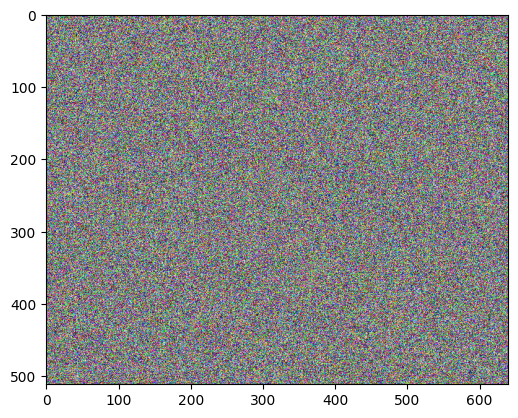

In [17]:
gen_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
show_img(gen_img)

run [50]:
run [100]:
run [150]:
run [200]:
run [250]:
run [300]:


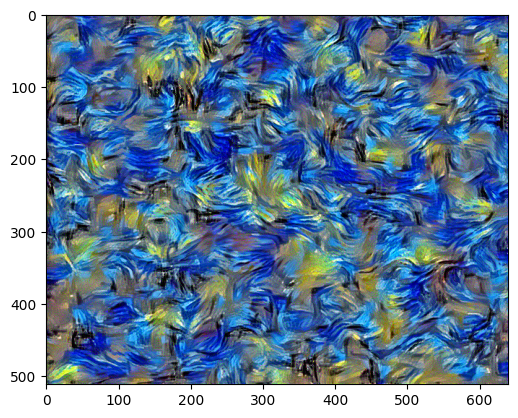

In [18]:
output = style_reconstruction(model, style_img, gen_img, 300)
show_img(output)

# Content Reconstruction

In [13]:
class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input


In [14]:
content_layers = ['conv_4']

def compute_content_loss(cnn, content_img, gen_img):
  cnn = copy.deepcopy(cnn)
  normalization = Normalization(model_norm_mean, model_norm_std).to(device)
  content_losses = []

  model = nn.Sequential(normalization)

  i = 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else:
      pass

    model.add_module(name, layer)

    if name == 'conv_4':
      target_feature = model(content_img).detach()
      content_loss = ContentLoss(target_feature)
      model.add_module("content_loss_{}".format(i), content_loss)
      content_losses.append(content_loss)

  for i in range(len(model)-1, -1, -1):
    if isinstance(model[i], ContentLoss):
      break

  model = model[:(i+1)]
  return model, content_losses

In [15]:
def content_reconstruction(cnn, content_img, gen_img, iterations):
  model, content_losses = compute_content_loss(cnn, content_img, gen_img)
  optimizer = optim.LBFGS([gen_img.requires_grad_()])
  run = [0]

  while run[0] <= iterations:
    def closure():
      gen_img.data.clamp_(0, 1)
      optimizer.zero_grad()
      model(gen_img)
      content_score = 0
      for cl in content_losses:
        content_score += cl.loss
      content_score.backward()
      run[0] += 1
      if run[0] % 50 == 0:
        print("run {}:".format(run))
        show_img(gen_img)
      return content_score

    optimizer.step(closure)

  gen_img.data.clamp_(0, 1)
  return gen_img

run [50]:


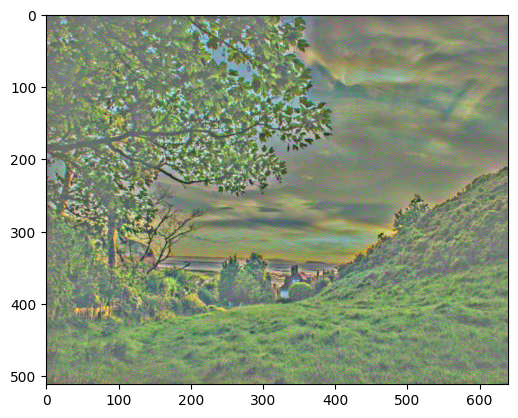

run [100]:


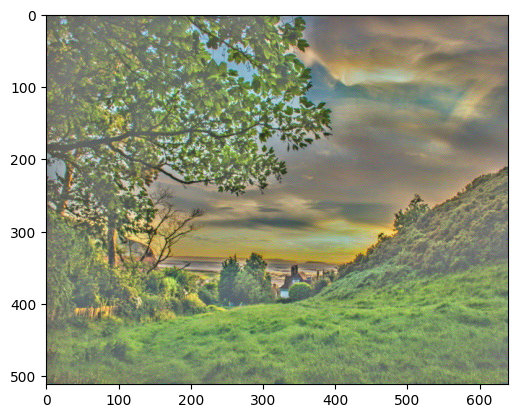

run [150]:


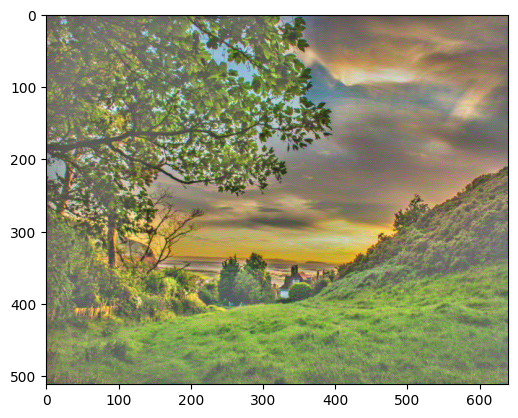

run [200]:


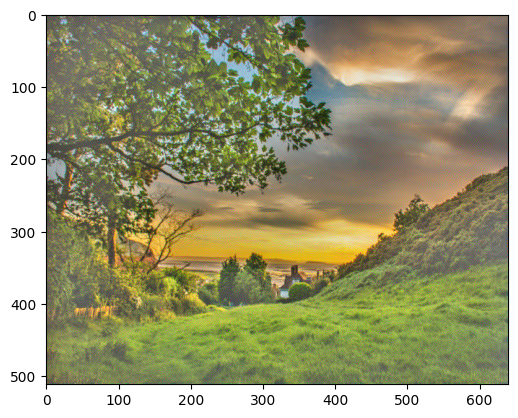

run [250]:


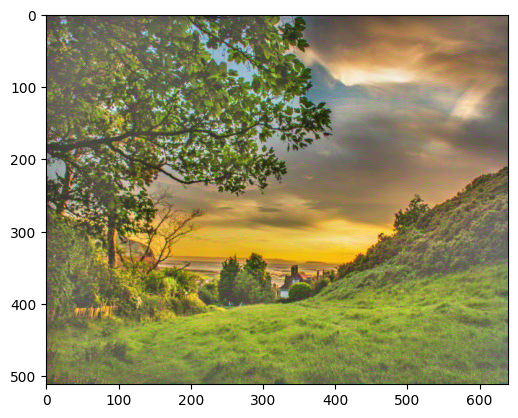

run [300]:


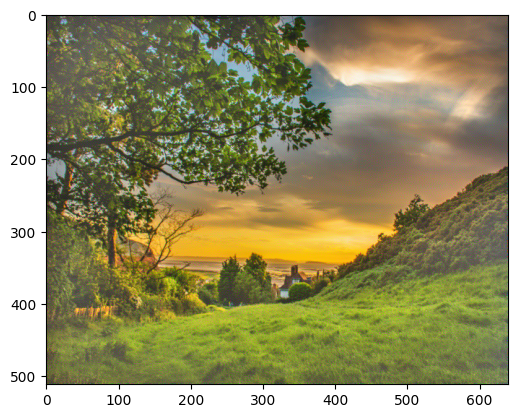

tensor([[[[0.4469, 0.4473, 0.1719,  ..., 0.8208, 0.3238, 0.5526],
          [0.5384, 0.0449, 0.0802,  ..., 0.1323, 0.5489, 0.4045],
          [0.1616, 0.3525, 0.2223,  ..., 0.4057, 0.5951, 0.2862],
          ...,
          [0.3952, 0.6476, 0.1971,  ..., 0.3757, 0.3969, 0.7732],
          [0.1025, 0.2490, 0.0000,  ..., 0.2406, 0.5570, 0.1909],
          [0.9807, 0.5711, 0.2725,  ..., 0.3848, 0.3030, 0.2682]],

         [[0.0000, 0.0000, 0.1470,  ..., 0.2072, 0.2605, 0.4957],
          [0.2364, 0.2439, 0.4406,  ..., 0.5973, 0.2247, 0.4600],
          [0.0000, 0.3712, 0.2708,  ..., 0.2567, 0.4369, 0.2737],
          ...,
          [0.4220, 0.0303, 0.3405,  ..., 0.5768, 0.3039, 0.2312],
          [0.4220, 0.4318, 0.5324,  ..., 0.5270, 0.3577, 0.4242],
          [0.3094, 0.2510, 0.3417,  ..., 0.3595, 0.5037, 0.8307]],

         [[0.5726, 0.5655, 0.5248,  ..., 0.2830, 0.7051, 0.0000],
          [0.0747, 0.0000, 0.0000,  ..., 0.1769, 0.3579, 0.2350],
          [0.6272, 0.0000, 0.0526,  ..., 0

In [16]:
gen_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
content_reconstruction(model, content_img, gen_img, 300)

# Style Transfer

In [24]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_losses(cnn, content_img, style_img, noise_image):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(model_norm_mean, model_norm_std).to(device)
    content_losses = []
    style_losses = []

    # 가장 먼저 입력 이미지가 입력 정규화(input normalization)를 수행하도록
    model = nn.Sequential(normalization)

    # 현재 CNN 모델에 포함되어 있는 모든 레이어를 확인하며
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # 설정한 content layer까지의 결과를 이용해 content loss를 계산
        if name in content_layers:
            target_feature = model(content_img).detach()
            content_loss = ContentLoss(target_feature)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        # 설정한 style layer까지의 결과를 이용해 style loss를 계산
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 마지막 loss 이후의 레이어는 사용하지 않도록
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, content_losses, style_losses

In [35]:
def style_transfer(cnn, content_img, style_img, input_img, iters):
    model, content_losses, style_losses = get_losses(cnn, content_img, style_img, input_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print("[ Start ]")
    show_img(input_img)

    run = [0]
    while run[0] <= iters:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            content_score = torch.tensor(0.0).to(device)
            style_score = torch.tensor(0.0).to(device)

            for cl in content_losses:
                content_score += cl.loss
            for sl in style_losses:
                style_score += sl.loss

            style_score *= 1e4
            loss = content_score + style_score
            loss.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print(f"[ Step: {run[0]} / Content loss: {content_score.item()} / Style loss: {style_score.item()}]")
                show_img(input_img)

            return content_score + style_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img


[ Start ]


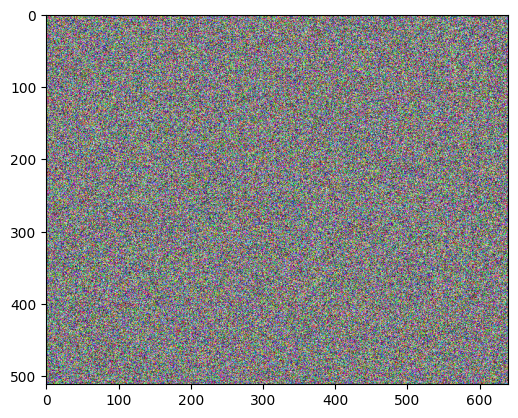

[ Step: 100 / Content loss: 14.543614387512207 / Style loss: 3.0592732429504395]


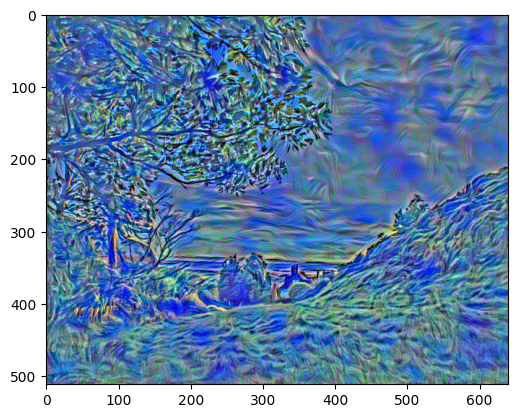

[ Step: 200 / Content loss: 11.506255149841309 / Style loss: 1.9710829257965088]


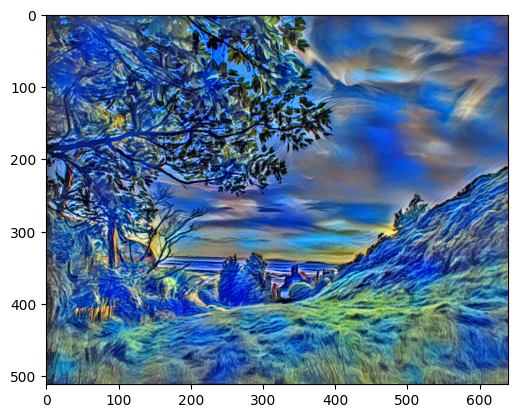

[ Step: 300 / Content loss: 11.923896789550781 / Style loss: 1.758699655532837]


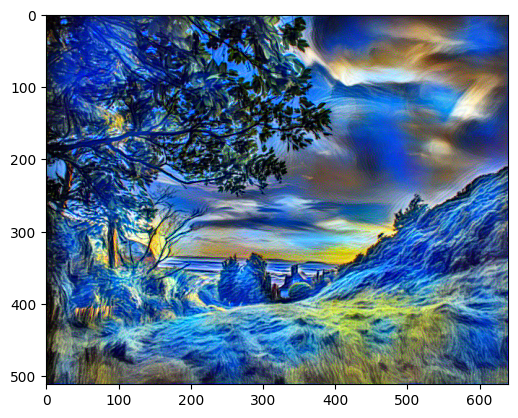

tensor([[[[1.5720e-01, 0.0000e+00, 1.5462e-01,  ..., 2.0011e-02,
           8.6902e-02, 5.9322e-02],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.0839e-01,
           5.2052e-01, 4.4072e-02],
          [1.3844e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           2.8040e-01, 5.2819e-02],
          ...,
          [1.3867e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 3.4774e-01],
          [4.1518e-01, 3.7330e-01, 1.3934e-01,  ..., 6.2755e-01,
           5.4973e-01, 5.0379e-01],
          [2.5359e-01, 2.7901e-02, 6.9156e-02,  ..., 0.0000e+00,
           0.0000e+00, 7.0902e-02]],

         [[0.0000e+00, 0.0000e+00, 1.6370e-03,  ..., 3.0742e-01,
           1.9134e-01, 7.0777e-02],
          [0.0000e+00, 0.0000e+00, 1.2599e-02,  ..., 2.8765e-01,
           1.8208e-01, 2.5087e-01],
          [2.7595e-03, 1.0015e-02, 1.1115e-01,  ..., 3.4762e-01,
           6.4880e-02, 4.4490e-01],
          ...,
          [1.5598e-01, 1.4249e-01, 2.0613e-01,  ..., 5.8250

In [36]:
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
style_transfer(model, content_img, style_img, input_img, 300)

looks like shit...